In [86]:
import os
import torch
import pandas as pd
from skimage import io, transform
from sklearn.model_selection import train_test_split
from PIL import Image
from sklearn.preprocessing import LabelEncoder
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torch.utils.data.sampler import SubsetRandomSampler
from torchvision import transforms, utils
import torch.nn as nn
import torch.optim as optim
import torchvision
from torchvision import models, datasets
import random
# Ignore warnings
import warnings
warnings.filterwarnings("ignore")

plt.ion()   # interactive mode

In [87]:
df = pd.read_csv('annotations/annotations.csv')
classes = df['class1'].unique()

idx_to_class = {i:j for i, j in enumerate(classes)}
class_to_idx = {value:key for key,value in idx_to_class.items()}

In [104]:
class CustomDataset(Dataset):
    def __init__(self, csv_file, image_dir, transform=None):
        self.data = pd.read_csv(csv_file)
        self.image_dir = image_dir
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):

        img_name = os.path.join(self.image_dir, self.data.iloc[idx, 2])
        image = Image.open(img_name)
        annotations = self.data.iloc[idx, 6:]  # Assuming annotations are in the third column
        annotations = np.array([annotations], dtype = np.float16).reshape(-1, 1)
        label = class_to_idx[self.data.iloc[idx, 3]]

        if self.transform:
            image = self.transform(image)

        return image, torch.tensor(label), torch.from_numpy(annotations)

# Define data transformations
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Load CSV annotations and split data
csv_file = 'annotations/annotations.csv'
image_dir = '.'
data = pd.read_csv(csv_file)

train_data, test_data = train_test_split(data, test_size=0.2, random_state=42)
train_data, val_data = train_test_split(train_data, test_size=0.1, random_state=42)

# Create custom datasets and data loaders
train_dataset = CustomDataset(csv_file=csv_file, image_dir=image_dir, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

test_dataset = CustomDataset(csv_file=csv_file, image_dir=image_dir, transform=transform)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

val_dataset = CustomDataset(csv_file=csv_file, image_dir=image_dir, transform=transform)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


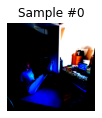

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


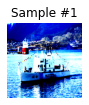

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


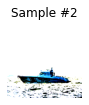

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


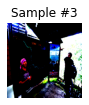

In [105]:
face_dataset = FacetDataset(csv_file='annotations/annotations.csv',
                                    root_dir='.')

fig = plt.figure()

for i, sample in enumerate(train_dataset):
    ax = plt.subplot(1, 4, i + 1)
    plt.imshow(np.transpose(sample[0], [1,2,0]))
    plt.tight_layout()
    ax.set_title('Sample #{}'.format(i))
    ax.axis('off')
    plt.show()
    if i == 3:
        break

In [115]:
device = torch.device('mps')
# Define your smaller ResNet student model
class TeacherResNet(nn.Module):
    def __init__(self, num_classes):
        super(TeacherResNet, self).__init__()
        self.resnet = models.resnet18(pretrained=True)
        # Replace the final classification layer to match the number of classes
        self.resnet.fc = nn.Linear(self.resnet.fc.in_features, num_classes)
    
    def forward(self, x):
        return self.resnet(x)

class StudentResNet(nn.Module):
    def __init__(self, num_classes):
        super(StudentResNet, self).__init__()
        self.resnet = models.resnet18(pretrained=False)
        # Replace the final classification layer to match the number of classes
        self.resnet.fc = nn.Linear(self.resnet.fc.in_features, num_classes)
    
    def forward(self, x):
        return self.resnet(x)

# Define loss functions
criterion_teacher = nn.CrossEntropyLoss()  # Loss for teacher model
criterion_student = nn.KLDivLoss()  # Knowledge distillation loss

# Instantiate the teacher and student models
teacher_model = TeacherResNet(num_classes=52).to(device)
student_model = StudentResNet(num_classes=52).to(device)  # Adjust num_classes as needed

# Load your custom datasets and data loaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

# Define optimizer for the student model
optimizer_student = optim.Adam(student_model.parameters(), lr=0.001)


In [116]:
# Training loop
num_epochs = 2  # Adjust as needed
for epoch in range(num_epochs):
    student_model.train()
    for images, labels, annotations in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer_student.zero_grad()
        
        # Forward pass
        teacher_outputs = teacher_model(images).to(device)
        student_outputs = student_model(images).to(device)
        
        # Compute loss for knowledge distillation
        kd_loss = criterion_student(
            torch.log_softmax(student_outputs / 5, dim=1),  # Apply temperature scaling
            torch.softmax(teacher_outputs / 5, dim=1)  # Apply temperature scaling
        )
        
        # Compute regular cross-entropy loss
        ce_loss = criterion_teacher(student_outputs, labels)
        
        # Combine the two losses with a weighting factor (alpha)
        alpha = 0.5  # Adjust as needed
        total_loss = alpha * kd_loss + (1 - alpha) * ce_loss
        
        total_loss.backward()
        optimizer_student.step()

   # Validation
    student_model.eval()
    val_loss = 0.0
    val_predictions = []
    val_targets = []

    with torch.no_grad():
        for images, labels, annotations in val_loader:
            images, labels = images.to(device), labels.to(device)
            # Forward pass
            student_outputs = student_model(images)
            
            # Compute cross-entropy loss for validation
            loss = criterion_teacher(student_outputs, labels)
            val_loss += loss.item()
            
            # Store predictions and ground truth labels for metrics
            val_predictions.extend(torch.argmax(student_outputs, dim=1).cpu().numpy())
            val_targets.extend(labels.cpu().numpy())

    # Calculate validation accuracy
    val_accuracy = accuracy_score(val_targets, val_predictions)
    
    # Print validation results for this epoch
    print(f'Epoch [{epoch+1}/{num_epochs}]'
          f' Val Loss: {val_loss / len(val_loader):.4f}'
          f' Val Accuracy: {val_accuracy:.4f}')

# Save the trained student model for future inference
torch.save(student_model.state_dict(), 'student_model.pth')



KeyboardInterrupt

